In [ ]:
from google.colab import files
uploaded = files.upload()

Saving All-Whale.wav to All-Whale (1).wav
Saving Label NON-Whale.txt to Label NON-Whale (1).txt
Saving Label Whale.txt to Label Whale (1).txt


In [ ]:
!ls /content/

 All-Whale.wav	       'Label Whale.txt'   whale_mfccs.csv
'Label NON-Whale.txt'   sample_data


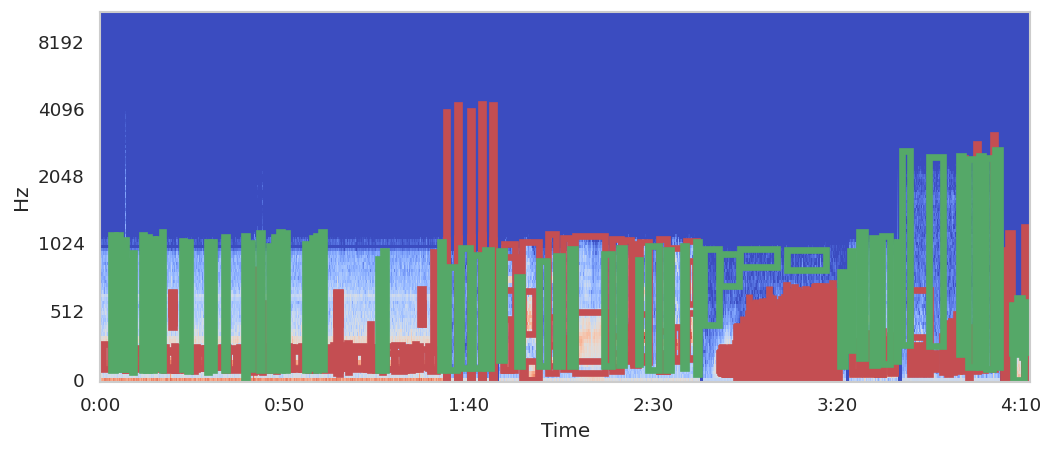

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd

def txt2df(file):
    with open(file) as f:
        labels = f.read()
        labels = [l.split('\t') for l in labels.split('\n')][:-1]
        labels = [l for o in labels for l in o]
        labels = [l for l in labels]
        labels = [l for l in labels if l != '\\']
        labels = np.array(labels).reshape(-1, 5)
        df = pd.DataFrame({'start': labels[:,0].astype(float), 'end': labels[:,1].astype(float),
                           'fmin': labels[:,3].astype(float), 'fmax': labels[:,4].astype(float),
                           'name': labels[:,2].astype(str)})
    return df

def rectangle(df_row, frequency):
    start, end, fmin, fmax = [df_row[o] for o in ['start', 'end','fmin', 'fmax']]
    if fmin == -1: fmin = 0
    if fmax == -1: fmax = frequency.max()
    xy = (start, fmin)
    width = end - start
    height = fmax - fmin
    return xy, width, height

# Spectrogram
data, sr = librosa.load("/content/All-Whale.wav")
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
spectrogram = librosa.power_to_db(spectrogram)

# Whale Labels
Whale_labels = txt2df("/content/Label Whale.txt")

# Non-Whale Labels
non_Whale_labels = txt2df("/content/Label NON-Whale.txt")

# Plot
fig, ax = plt.subplots(figsize=(10,4), dpi=120)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=ax)

for i in range(len(Whale_labels)):
    ax.add_patch(Rectangle(*rectangle(Whale_labels.iloc[i], ax.axis()[2:]), fc='none', ec='r', lw=4))

for i in range(len(non_Whale_labels)):
    ax.add_patch(Rectangle(*rectangle(non_Whale_labels.iloc[i], ax.axis()[2:]), fc='none', ec='g', lw=4))

plt.show()


In [ ]:
!ls /content/

 All-Whale.wav	       'Label Whale.txt'   whale_mfccs.csv
'Label NON-Whale.txt'   sample_data


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to extract MFCCs from an audio file
def extract_mfccs(file_path):
    waveform, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    return mfccs

# Audio file path
audio_file = "/content/All-Whale.wav"

# Load labels from text files
def load_labels(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        start, end, label = line.strip().split('\t')
        label = label.replace('\\', '')
        start = start.replace('\\', '')  # Remove escape characters from start time
        end = end.replace('\\', '')      # Remove escape characters from end time
        try:
            start_time = float(start)
            end_time = float(end)
            labels.append((start_time, end_time, label))
        except ValueError:
            print(f"Error converting times to float: {start}, {end}")
    return labels




whale_labels = load_labels('/content/Label Whale.txt')
non_whale_labels = load_labels('/content/Label NON-Whale.txt')

# Extract MFCCs from the audio file
mfccs = extract_mfccs(audio_file)

# Create a DataFrame to store MFCCs and labels
data = []

hop_length = 512  # Adjust as needed
sr = 22050  # Adjust as needed

for frame_idx in range(mfccs.shape[1]):
    time = frame_idx * hop_length / sr
    label = 'whale' if any(start <= time <= end for start, end, _ in whale_labels) else 'non-whale'
    mfcc_values = mfccs[:, frame_idx]
    data.append((time, label, *mfcc_values))

columns = ['time', 'label'] + [f'mfcc_{i+1}' for i in range(mfccs.shape[0])]
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
output_csv = '/content/whale_mfccs.csv'
df.to_csv(output_csv, index=False)

# Load the dataset
df = pd.read_csv(output_csv)

# Split features and labels
X = df.drop(['time', 'label'], axis=1)
y = df['label']

# Convert class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and print the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Error converting times to float: , 104.244533
Error converting times to float: , 77.918755
Error converting times to float: , 77.136158
Error converting times to float: , 101.407028
Error converting times to float: , 89.575562
Error converting times to float: , 92.782250
Error converting times to float: , 71.509885
Error converting times to float: , 74.071457
Error converting times to float: , 387.461818
Error converting times to float: , 101.407028
Error converting times to float: , 85.670685
Error converting times to float: , 89.575562
Error converting times to float: , 78.408864
Error converting times to float: , 97.443649
Error converting times to float: , 86.393750
Error converting times to float: , 79.159652
Error converting times to float: , 95.402610
Error converting times to float: , 395.220917
Error converting times to float: , 88.206595
Error converting times to float: , 92.222242
Error converting times to float: , 93.499802
Error converting times to float: , 76.477498
Error

Error converting times to float: , 104.244533
Error converting times to float: , 77.918755
Error converting times to float: , 77.136158
Error converting times to float: , 101.407028
Error converting times to float: , 89.575562
Error converting times to float: , 92.782250
Error converting times to float: , 71.509885
Error converting times to float: , 74.071457
Error converting times to float: , 387.461818
Error converting times to float: , 101.407028
Error converting times to float: , 85.670685
Error converting times to float: , 89.575562
Error converting times to float: , 78.408864
Error converting times to float: , 97.443649
Error converting times to float: , 86.393750
Error converting times to float: , 79.159652
Error converting times to float: , 95.402610
Error converting times to float: , 395.220917
Error converting times to float: , 88.206595
Error converting times to float: , 92.222242
Error converting times to float: , 93.499802
Error converting times to float: , 76.477498
Error

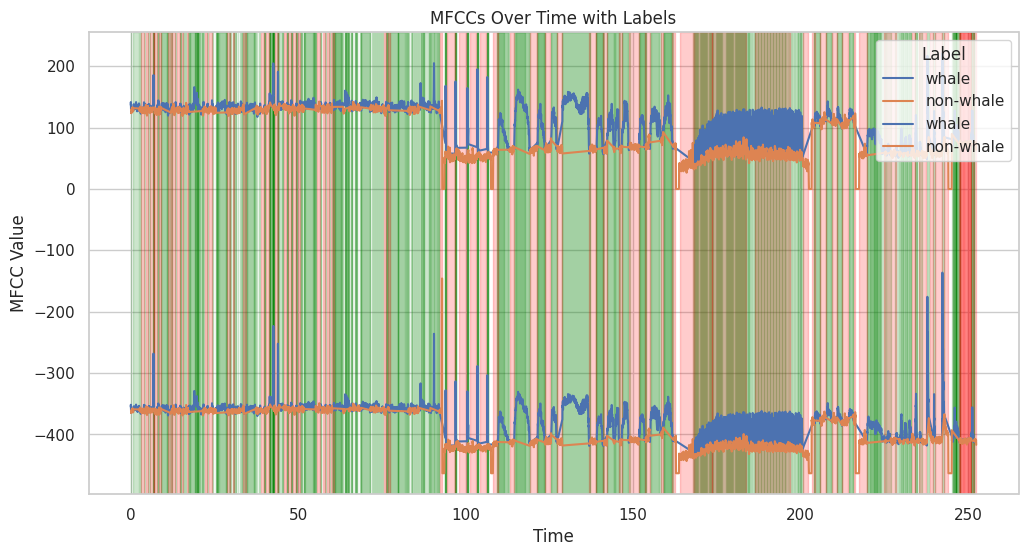

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(output_csv)

# Load label data
whale_labels = load_labels('/content/Label Whale.txt')
non_whale_labels = load_labels('/content/Label NON-Whale.txt')

# Set style
sns.set(style="whitegrid")

# Plot MFCCs over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='time', y='mfcc_1', hue='label')
sns.lineplot(data=df, x='time', y='mfcc_2', hue='label')
# Repeat the above line for more MFCCs as needed

# Plot whale labels
for start, end, _ in whale_labels:
    plt.axvspan(start, end, color='green', alpha=0.2)

# Plot non-whale labels
for start, end, _ in non_whale_labels:
    plt.axvspan(start, end, color='red', alpha=0.2)

plt.title('MFCCs Over Time with Labels')
plt.xlabel('Time')
plt.ylabel('MFCC Value')
plt.legend(title='Label', loc='upper right')
plt.show()


In [ ]:
!ls /content/

 All-Whale.wav	       'Label Whale.txt'   whale_mfccs.csv
'Label NON-Whale.txt'   sample_data


Error converting times to float: , 104.244533
Error converting times to float: , 77.918755
Error converting times to float: , 77.136158
Error converting times to float: , 101.407028
Error converting times to float: , 89.575562
Error converting times to float: , 92.782250
Error converting times to float: , 71.509885
Error converting times to float: , 74.071457
Error converting times to float: , 387.461818
Error converting times to float: , 101.407028
Error converting times to float: , 85.670685
Error converting times to float: , 89.575562
Error converting times to float: , 78.408864
Error converting times to float: , 97.443649
Error converting times to float: , 86.393750
Error converting times to float: , 79.159652
Error converting times to float: , 95.402610
Error converting times to float: , 395.220917
Error converting times to float: , 88.206595
Error converting times to float: , 92.222242
Error converting times to float: , 93.499802
Error converting times to float: , 76.477498
Error

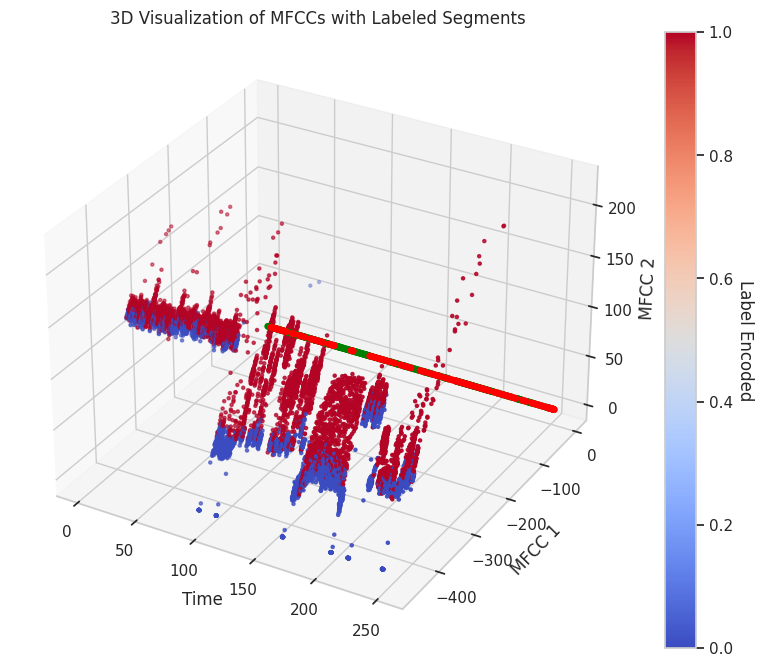

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Load the dataset
df = pd.read_csv(output_csv)

# Load label data
whale_labels = load_labels('/content/Label Whale.txt')
non_whale_labels = load_labels('/content/Label NON-Whale.txt')

# Convert labels to integers using LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Set style
sns.set(style="whitegrid")

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot MFCCs as dots in 3D space
sc = ax.scatter(df['time'], df['mfcc_1'], df['mfcc_2'], c=df['label_encoded'], cmap='coolwarm', marker='.')

# Plot whale labels
for start, end, _ in whale_labels:
    ax.plot([start, end], [0, 0], [0, 0], color='green', linewidth=5)

# Plot non-whale labels
for start, end, _ in non_whale_labels:
    ax.plot([start, end], [0, 0], [0, 0], color='red', linewidth=5)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('MFCC 1')
ax.set_zlabel('MFCC 2')
ax.set_title('3D Visualization of MFCCs with Labeled Segments')

# Add a color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Label Encoded', rotation=270, labelpad=15)

plt.show()


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to extract MFCCs from an audio file
def extract_mfccs(file_path):
    waveform, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
    return mfccs


# Load labels from text files
def load_labels(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        start, end, label = line.strip().split('\t')
        label = label.replace('\\', '')
        start = start.replace('\\', '')  # Remove escape characters from start time
        end = end.replace('\\', '')      # Remove escape characters from end time
        try:
            start_time = float(start)
            end_time = float(end)
            labels.append((start_time, end_time, label))
        except ValueError:
            print(f"Error converting times to float: {start}, {end}")
    return labels


whale_labels = load_labels('/content/Label Whale.txt')
non_whale_labels = load_labels('/content/Label NON-Whale.txt')

# Extract MFCCs from the audio file
mfccs = extract_mfccs(audio_file)

# Create a DataFrame to store MFCCs and labels
data = []

hop_length = 512  # Adjust as needed
sr = 22050  # Adjust as needed

for frame_idx in range(mfccs.shape[1]):
    time = frame_idx * hop_length / sr
    label = 'whale' if any(start <= time <= end for start, end, _ in whale_labels) else 'non-whale'
    mfcc_values = mfccs[:, frame_idx]
    data.append((time, label, *mfcc_values))

columns = ['time', 'label'] + [f'mfcc_{i+1}' for i in range(mfccs.shape[0])]
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
output_csv = '/content/whale_mfccs.csv'
df.to_csv(output_csv, index=False)

# Load the dataset
df = pd.read_csv(output_csv)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy and print the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Error converting times to float: , 104.244533
Error converting times to float: , 77.918755
Error converting times to float: , 77.136158
Error converting times to float: , 101.407028
Error converting times to float: , 89.575562
Error converting times to float: , 92.782250
Error converting times to float: , 71.509885
Error converting times to float: , 74.071457
Error converting times to float: , 387.461818
Error converting times to float: , 101.407028
Error converting times to float: , 85.670685
Error converting times to float: , 89.575562
Error converting times to float: , 78.408864
Error converting times to float: , 97.443649
Error converting times to float: , 86.393750
Error converting times to float: , 79.159652
Error converting times to float: , 95.402610
Error converting times to float: , 395.220917
Error converting times to float: , 88.206595
Error converting times to float: , 92.222242
Error converting times to float: , 93.499802
Error converting times to float: , 76.477498
Error

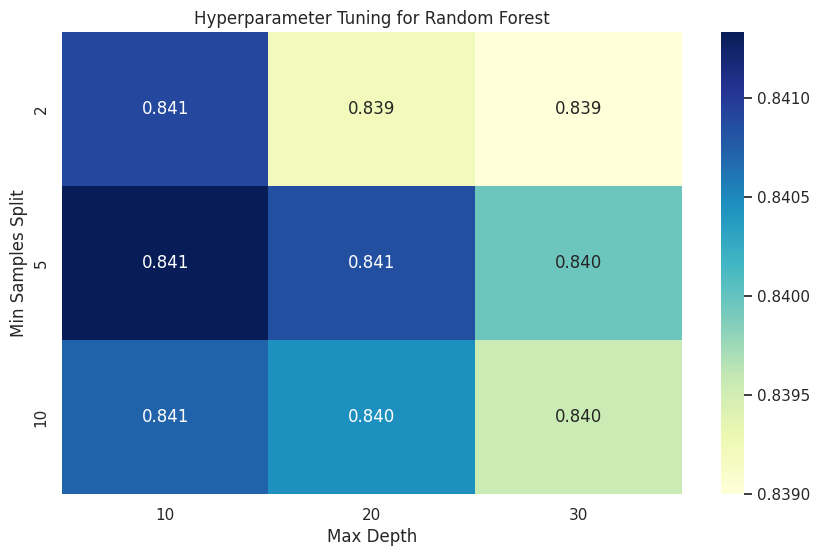

In [ ]:
import seaborn as sns

# Extract the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the DataFrame to have 'max_depth' on the x-axis and 'param_min_samples_split' on the y-axis
pivot_table = results.pivot_table(index='param_min_samples_split', columns='param_max_depth', values='mean_test_score')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".3f", cbar=True)
plt.title('Hyperparameter Tuning for Random Forest')
plt.xlabel('Max Depth')
plt.ylabel('Min Samples Split')
plt.show()
# Hyperparameter Tuning Visualization - Heatmap:

In [ ]:
# Load the dataset
df = pd.read_csv(output_csv)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy and print the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8513637756665645
Confusion Matrix:
[[1242  217]
 [ 268 1536]]


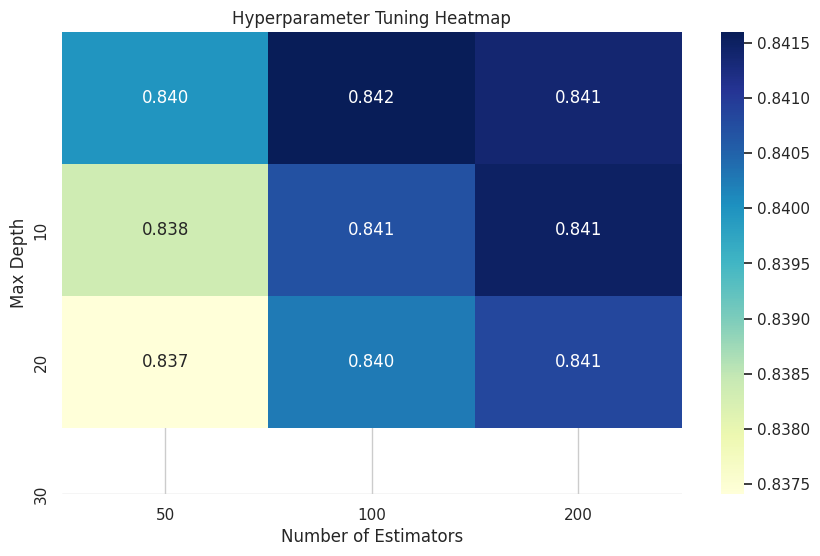

In [ ]:
import seaborn as sns

# Access the cv_results_ attribute of the GridSearchCV object
cv_results = grid_search.cv_results_

# Get the relevant data for visualization
param_grid = grid_search.param_grid
max_depth_values = param_grid['max_depth']
n_estimators_values = param_grid['n_estimators']

# Create a DataFrame from cv_results
results_df = pd.DataFrame(cv_results)

# Pivot the DataFrame to have 'param_max_depth' on the x-axis and 'param_n_estimators' on the y-axis
pivot_table = results_df.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
plt.title("Hyperparameter Tuning Heatmap")
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=n_estimators_values, yticklabels=max_depth_values)
plt.xlabel("Number of Estimators")
plt.ylabel("Max Depth")
plt.show()
# Hyperparameter Tuning Visualization - Heatmap:

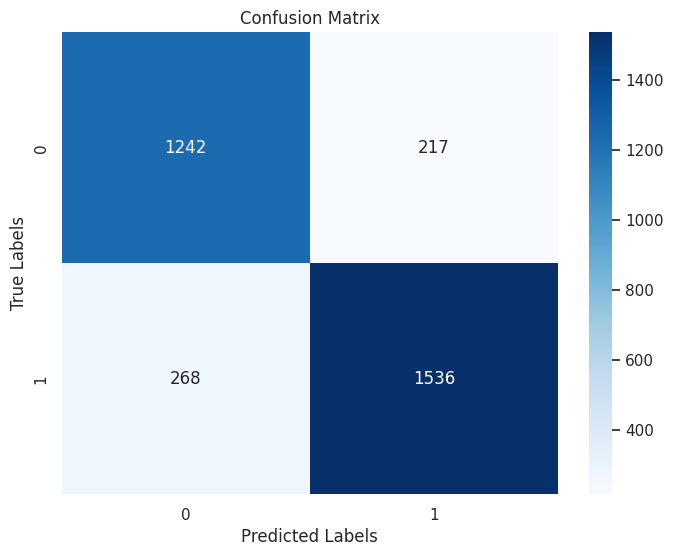

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


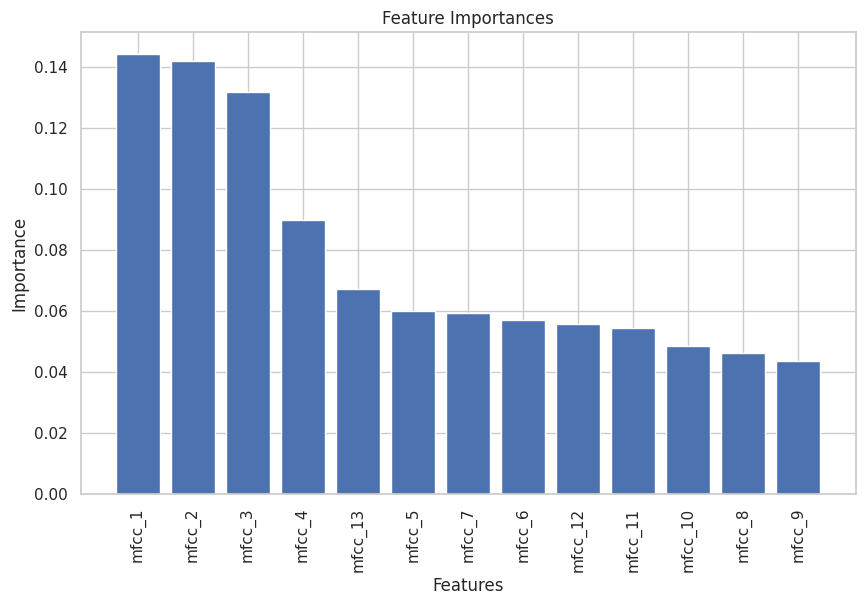

In [ ]:
# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()
# Feature Importance Visualization:

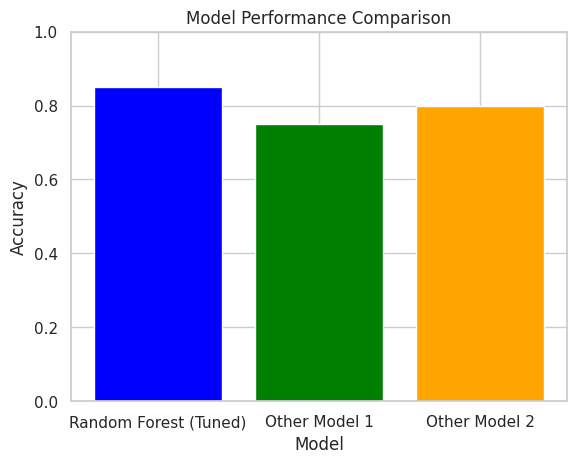

In [ ]:
# Create a bar plot to compare model accuracies
models = ['Random Forest (Tuned)', 'Other Model 1', 'Other Model 2']
accuracies = [0.8513637756665645, 0.75, 0.80]  # Replace with your actual accuracy values

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
